# Testing different models configurations

In [51]:
import os
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io
import numpy as np
import pandas as pd
import librosa
from python_speech_features import mfcc
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import wandb
from sklearn.metrics import confusion_matrix
import sklearn
import itertools
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional
import tensorflow_io as tfio
from sklearn.model_selection import KFold
import time

In [52]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [53]:
tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [54]:
timit_map_str = """
h# 0
d 1
ih 2
dcl 3
jh 4
ux 5
n 6
ow 7
hv 8
iy 9
z 10
ae 11
v 12
axr 13
tcl 14
t 15
ay 16
ng 17
hh 18
m 19
r 20
ey 21
ax 22
kcl 23
k 24
w 25
q 26
ix 27
f 28
s 29
l 30
dh 31
epi 32
eh 33
b 34
ao 35
th 36
er 37
bcl 38
aw 39
y 40
aa 41
ax-h 42
ah 43
nx 44
en 45
ch 46
sh 47
pcl 48
p 49
dx 50
el 51
oy 52
gcl 53
g 54
pau 55
uw 56
zh 57
uh 58
em 59
eng 60
"""
timit_char_map = {}
timit_index_map = {}
for line in timit_map_str.strip().split('\n'):
	ch, index = line.split()
	timit_char_map[ch] = int(index)
	timit_index_map[int(index)] = ch

In [55]:
TRAIN='./timit_LDC93S1/timit/TIMIT/TRAIN/'
train_phn = []
train_mfcc = []
train_timesteps=[]
for dr1 in os.listdir(TRAIN):
    dr1_path=TRAIN+dr1+'/'
    for dr2 in os.listdir(dr1_path):
        dr2_path=dr1_path+dr2+'/'
        for filename in os.listdir(dr2_path):
            if filename.endswith(".WAV"):# and filename[:2]!='SA':
                title = filename.split('.')[0]
                
                # mfcc
                x, sr = librosa.load(dr2_path+title+'.WAV',sr=16000)
                mfcc_feat = mfcc(x,sr)
                # phn
                f = open(dr2_path+title+'.PHN', "r")
                phn_file = f.read().split()
                f.close()
                
                labels = []
                t = 12.5*16
                timesteps = []
                for i in range(0,int(len(phn_file)/3)):
                    while(eval(phn_file[i*3]) <= t and t < eval(phn_file[i*3+1])):
                        labels.append(phn_file[i*3+2])
                        timesteps.append(t)
                        t+=160
                        
                if (len(mfcc_feat) - len(labels)) == 1:
                    labels.append('h#')
                    
                if len(mfcc_feat) == len(labels):
                    train_mfcc.append(np.array(mfcc_feat))
                    train_phn.append(np.array([tf.keras.utils.to_categorical(timit_char_map[pub],61) for pub in labels]))
                    train_timesteps.append(np.array(timesteps))
                    
                    # masked
                    mfcc_masked = tfio.experimental.audio.freq_mask(mfcc_feat, param=10)
                    for _ in range(0,int(mfcc_feat.shape[0]/50)):
                        mfcc_masked = tfio.experimental.audio.time_mask(mfcc_masked, param=5)
                        
                    train_mfcc.append(np.array(mfcc_masked))
                    train_phn.append(np.array([tf.keras.utils.to_categorical(timit_char_map[pub],61) for pub in labels]))
                    train_timesteps.append(np.array(timesteps))
                    

In [56]:
TEST='./timit_LDC93S1/timit/TIMIT/TEST/'
test_phn = []
test_mfcc = []
test_timesteps=[]
for dr1 in os.listdir(TEST):
    dr1_path=TEST+dr1+'/'
    for dr2 in os.listdir(dr1_path):
        dr2_path=dr1_path+dr2+'/'
        for filename in os.listdir(dr2_path):
            if filename.endswith(".WAV"): #and filename[:2]!='SA':
                title = filename.split('.')[0]
                
                # mfcc
                x, sr = librosa.load(dr2_path+title+'.WAV',sr=16000)
                mfcc_feat = mfcc(x,sr)
                # phn
                f = open(dr2_path+title+'.PHN', "r")
                phn_file = f.read().split()
                f.close()
                
                labels = []
                t = 12.5*16
                timesteps = []
                for i in range(0,int(len(phn_file)/3)):
                    while(eval(phn_file[i*3]) <= t and t < eval(phn_file[i*3+1])):
                        labels.append(phn_file[i*3+2])
                        timesteps.append(t)
                        t+=160
                
                if (len(mfcc_feat) - len(labels)) == 1:
                    labels.append('h#')
                    
                if len(mfcc_feat) == len(labels):
                    test_mfcc.append(np.array(mfcc_feat))
                    test_phn.append(np.array([tf.keras.utils.to_categorical(timit_char_map[pub],61) for pub in labels]))
                    test_timesteps.append(np.array(timesteps))

In [57]:
def train_valid_generator(set_indexes):
        while True:
            i = np.random.randint(0, len(set_indexes))
            yield train_mfcc[set_indexes[i]][np.newaxis,:,:], train_phn[set_indexes[i]][np.newaxis,:]

In [58]:
def train_generator():
    while True:
        i = np.random.randint(0, len(train_phn))
        yield train_mfcc[i][np.newaxis,:,:], train_phn[i][np.newaxis,:]

In [59]:
def test_generator():
    while True:
        i = np.random.randint(0, len(test_mfcc))
        yield test_mfcc[i][np.newaxis,:,:], test_phn[i][np.newaxis,:]

In [60]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [61]:
visime_map_str = """
h# 0
d 5
ih 2
dcl 0 
jh 7
ux 2
n 6
ow 9 
hv 7
iy 2
z 5
ae 8 
v 3
axr 2
tcl 0 
t 5
ay 10 
ng 6
hh 6
m 1 
r 7
ey 8 
ax 2
kcl 0 
k 6
w 4
q 0 
ix 2
f 3
s 7
l 6
dh 5
epi 0 
eh 8 
b 1 
ao 9 
th 5
er 7
bcl 0 
aw 9 
y 2
aa 9
ax-h 2
ah 10
nx 6
en 6
ch 7
sh 7
pcl 0 
p 1
dx 6
el 6
oy 9
gcl 0 
g 6
pau 0 
uw 4
zh 7
uh 4
em 1
eng 6
"""
visime_char_map = {}
visime_index_map = {}
for line in visime_map_str.strip().split('\n'):
	ch, index = line.split()
	visime_char_map[ch] = int(index)
	visime_index_map[int(index)] = ch

# Bidirectional LSTM

Epoch 1/30
1000/1000 [==============================] - 21s 20ms/step - loss: 2.8406 - accuracy: 0.2737 - val_loss: 2.1803 - val_accuracy: 0.3939
Epoch 2/30
1000/1000 [==============================] - 19s 19ms/step - loss: 2.0581 - accuracy: 0.4242 - val_loss: 1.7661 - val_accuracy: 0.4909
Epoch 3/30
1000/1000 [==============================] - 19s 19ms/step - loss: 1.8766 - accuracy: 0.4693 - val_loss: 1.7039 - val_accuracy: 0.4891
Epoch 4/30
1000/1000 [==============================] - 19s 19ms/step - loss: 1.7695 - accuracy: 0.4952 - val_loss: 1.5945 - val_accuracy: 0.5477
Epoch 5/30
1000/1000 [==============================] - 19s 19ms/step - loss: 1.6778 - accuracy: 0.5138 - val_loss: 1.5630 - val_accuracy: 0.5342
Epoch 6/30
1000/1000 [==============================] - 19s 19ms/step - loss: 1.6561 - accuracy: 0.5197 - val_loss: 1.4856 - val_accuracy: 0.5528
Epoch 7/30
1000/1000 [==============================] - 19s 19ms/step - loss: 1.5524 - accuracy: 0.5476 - val_loss: 1.3194 -

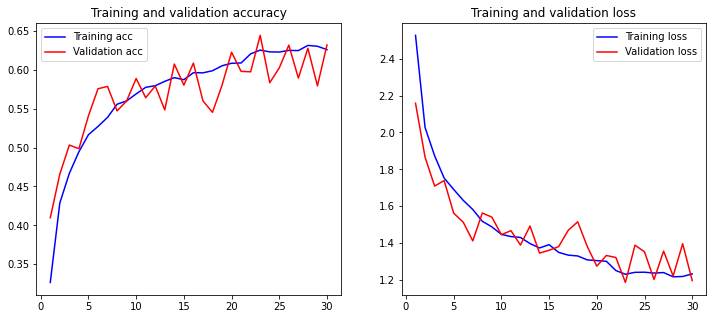

In [62]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Dense(64, activation='relu',input_shape=(None,13)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True,dropout=0.2)))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    tf.keras.backend.clear_session()
    
    
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=50,steps_per_epoch=1000,epochs=30, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=500,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: "+str(moy_train/k))
    print("Testing Accuracy: "+str(moy_test/k)+"\n")
    plot_history(history)
    model.save("models/BI_LSTM_128_30epochs.h5")
    
    t0 = time.time()
    pred_labels = []
    true_labels = []

    for i in range(0,len(test_mfcc)):
        pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
        pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
        true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

    flat_pred = [item for sublist in pred_labels for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    print("Phone accuracy on full test set: "+str(accuracy_score(flat_true, flat_pred))+"\n")
    t1 = time.time()

    print("Time to evaluate the test set: "+str(t1-t0)+"\n")
        
    flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
    flat_vis_true = [visime_char_map[ph] for ph in flat_true]
    
    print("Visime accuracy on full test set: "+str(accuracy_score(flat_vis_true, flat_vis_pred))+"\n")

# LSTM

Epoch 1/30
1000/1000 [==============================] - 14s 13ms/step - loss: 2.9993 - accuracy: 0.2456 - val_loss: 2.2960 - val_accuracy: 0.3673
Epoch 2/30
1000/1000 [==============================] - 12s 12ms/step - loss: 2.3073 - accuracy: 0.3625 - val_loss: 2.0767 - val_accuracy: 0.4194
Epoch 3/30
1000/1000 [==============================] - 12s 12ms/step - loss: 2.1766 - accuracy: 0.3951 - val_loss: 2.0377 - val_accuracy: 0.4305
Epoch 4/30
1000/1000 [==============================] - 12s 12ms/step - loss: 2.0406 - accuracy: 0.4186 - val_loss: 1.9867 - val_accuracy: 0.4375
Epoch 5/30
1000/1000 [==============================] - 12s 12ms/step - loss: 1.9660 - accuracy: 0.4459 - val_loss: 1.8381 - val_accuracy: 0.4786
Epoch 6/30
1000/1000 [==============================] - 12s 12ms/step - loss: 1.9594 - accuracy: 0.4449 - val_loss: 1.8815 - val_accuracy: 0.4631
Epoch 7/30
1000/1000 [==============================] - 12s 12ms/step - loss: 1.8599 - accuracy: 0.4687 - val_loss: 1.7555 -

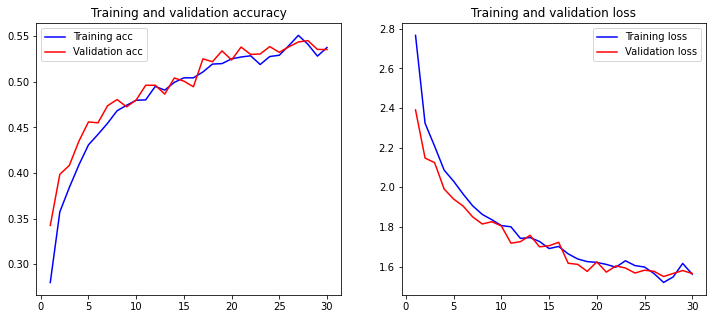

In [63]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Dense(64, activation='relu',input_shape=(None,13)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True,dropout=0.2))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    tf.keras.backend.clear_session()
    
    
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=500,steps_per_epoch=1000,epochs=30, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=500,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: "+str(moy_train/k))
    print("Testing Accuracy: "+str(moy_test/k)+"\n")
    plot_history(history)
    model.save("models/LSTM_128_30epochs.h5")
    
    t0 = time.time()
    pred_labels = []
    true_labels = []

    for i in range(0,len(test_mfcc)):
        pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
        pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
        true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

    flat_pred = [item for sublist in pred_labels for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    print("Phone accuracy on full test set: "+str(accuracy_score(flat_true, flat_pred))+"\n")
    t1 = time.time()

    print("Time to evaluate the test set: "+str(t1-t0)+"\n")
        
    flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
    flat_vis_true = [visime_char_map[ph] for ph in flat_true]
    
    print("Visime accuracy on full test set: "+str(accuracy_score(flat_vis_true, flat_vis_pred))+"\n")

# Conv1d + LSTM

Epoch 1/30
1000/1000 [==============================] - 14s 13ms/step - loss: 2.9305 - accuracy: 0.2585 - val_loss: 2.2536 - val_accuracy: 0.3764
Epoch 2/30
1000/1000 [==============================] - 13s 13ms/step - loss: 2.2109 - accuracy: 0.3778 - val_loss: 2.0878 - val_accuracy: 0.4160
Epoch 3/30
1000/1000 [==============================] - 13s 13ms/step - loss: 2.0958 - accuracy: 0.4099 - val_loss: 1.9290 - val_accuracy: 0.4580
Epoch 4/30
1000/1000 [==============================] - 12s 12ms/step - loss: 1.9828 - accuracy: 0.4363 - val_loss: 1.8799 - val_accuracy: 0.4613
Epoch 5/30
1000/1000 [==============================] - 12s 12ms/step - loss: 1.8808 - accuracy: 0.4582 - val_loss: 1.8195 - val_accuracy: 0.4723
Epoch 6/30
1000/1000 [==============================] - 12s 12ms/step - loss: 1.8745 - accuracy: 0.4659 - val_loss: 1.8369 - val_accuracy: 0.4704
Epoch 7/30
1000/1000 [==============================] - 13s 13ms/step - loss: 1.7596 - accuracy: 0.4896 - val_loss: 1.7149 -

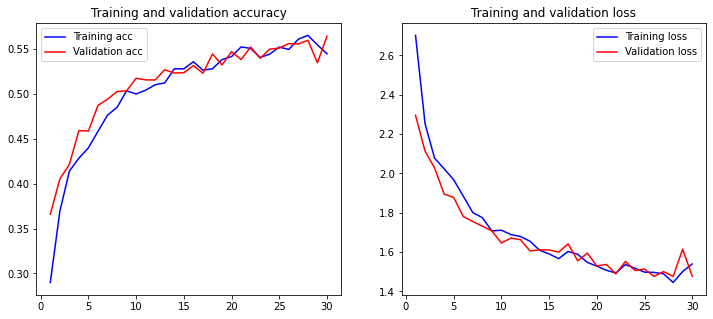

In [64]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv1D(filters=32,
                    input_shape=(None,13),
                   kernel_size=8,
                   strides=1,
                   activation='relu',
                   padding='same'))
    model.add(Dense(64, activation='relu',input_shape=(None,13)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=True,dropout=0.2))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    tf.keras.backend.clear_session()
    
    
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=500,steps_per_epoch=1000,epochs=30, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=500,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: "+str(moy_train/k))
    print("Testing Accuracy: "+str(moy_test/k)+"\n")
    plot_history(history)
    model.save("models/Conv1D_LSTM_128_30epochs.h5")
    
    t0 = time.time()
    pred_labels = []
    true_labels = []

    for i in range(0,len(test_mfcc)):
        pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
        pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
        true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

    flat_pred = [item for sublist in pred_labels for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    print("Phone accuracy on full test set: "+str(accuracy_score(flat_true, flat_pred))+"\n")
    t1 = time.time()

    print("Time to evaluate the test set: "+str(t1-t0)+"\n")
        
    flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
    flat_vis_true = [visime_char_map[ph] for ph in flat_true]
    
    print("Visime accuracy on full test set: "+str(accuracy_score(flat_vis_true, flat_vis_pred))+"\n")

# Conv 1d + Bidirectional LSTM

Epoch 1/30
1000/1000 [==============================] - 25s 23ms/step - loss: 2.8748 - accuracy: 0.2688 - val_loss: 2.0983 - val_accuracy: 0.4094
Epoch 2/30
1000/1000 [==============================] - 23s 23ms/step - loss: 2.0399 - accuracy: 0.4258 - val_loss: 1.9326 - val_accuracy: 0.4522
Epoch 3/30
1000/1000 [==============================] - 23s 23ms/step - loss: 1.9141 - accuracy: 0.4577 - val_loss: 1.7654 - val_accuracy: 0.4933
Epoch 4/30
1000/1000 [==============================] - 23s 23ms/step - loss: 1.8132 - accuracy: 0.4839 - val_loss: 1.7026 - val_accuracy: 0.5119
Epoch 5/30
1000/1000 [==============================] - 23s 23ms/step - loss: 1.7042 - accuracy: 0.5101 - val_loss: 1.6278 - val_accuracy: 0.5260
Epoch 6/30
1000/1000 [==============================] - 23s 23ms/step - loss: 1.6099 - accuracy: 0.5336 - val_loss: 1.5977 - val_accuracy: 0.5344
Epoch 7/30
1000/1000 [==============================] - 23s 23ms/step - loss: 1.6131 - accuracy: 0.5343 - val_loss: 1.5947 -

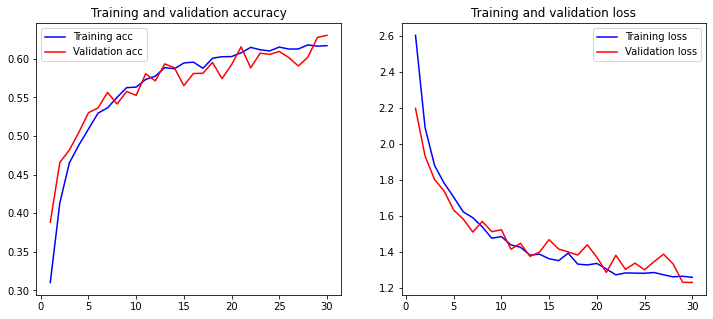

In [65]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv1D(filters=32,
                    input_shape=(None,13),
                   kernel_size=8,
                   strides=1,
                   activation='relu',
                   padding='same'))
    model.add(Dense(64, activation='relu',input_shape=(None,13)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True,dropout=0.2)))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    tf.keras.backend.clear_session()
    
    
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=500,steps_per_epoch=1000,epochs=30, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=500,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: "+str(moy_train/k))
    print("Testing Accuracy: "+str(moy_test/k)+"\n")
    plot_history(history)
    model.save("models/Conv1D_BI_LSTM_128_30epochs.h5")
    
    t0 = time.time()
    pred_labels = []
    true_labels = []

    for i in range(0,len(test_mfcc)):
        pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
        pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
        true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

    flat_pred = [item for sublist in pred_labels for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    print("Phone accuracy on full test set: "+str(accuracy_score(flat_true, flat_pred))+"\n")
    t1 = time.time()

    print("Time to evaluate the test set: "+str(t1-t0)+"\n")
        
    flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
    flat_vis_true = [visime_char_map[ph] for ph in flat_true]
    
    print("Visime accuracy on full test set: "+str(accuracy_score(flat_vis_true, flat_vis_pred))+"\n")

# Bidirectional LSTM nodes numbers testing

# 256 LSTM nodes

Epoch 1/30
1000/1000 [==============================] - 21s 20ms/step - loss: 2.6860 - accuracy: 0.3006 - val_loss: 1.9227 - val_accuracy: 0.4506
Epoch 2/30
1000/1000 [==============================] - 20s 20ms/step - loss: 1.9163 - accuracy: 0.4572 - val_loss: 1.8646 - val_accuracy: 0.4894
Epoch 3/30
1000/1000 [==============================] - 20s 20ms/step - loss: 1.7679 - accuracy: 0.4949 - val_loss: 1.6723 - val_accuracy: 0.5100
Epoch 4/30
1000/1000 [==============================] - 20s 20ms/step - loss: 1.6661 - accuracy: 0.5194 - val_loss: 1.5568 - val_accuracy: 0.5343
Epoch 5/30
1000/1000 [==============================] - 19s 19ms/step - loss: 1.5431 - accuracy: 0.5485 - val_loss: 1.5378 - val_accuracy: 0.5487
Epoch 6/30
1000/1000 [==============================] - 20s 20ms/step - loss: 1.4671 - accuracy: 0.5688 - val_loss: 1.3620 - val_accuracy: 0.5954
Epoch 7/30
1000/1000 [==============================] - 20s 20ms/step - loss: 1.4525 - accuracy: 0.5739 - val_loss: 1.3008 -

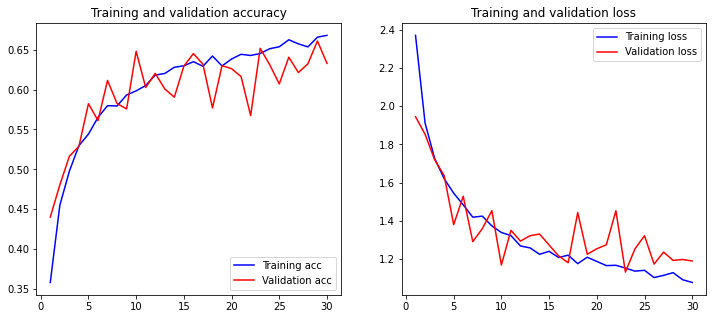

In [68]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Dense(128, activation='relu',input_shape=(None,13)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True,dropout=0.2)))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    tf.keras.backend.clear_session()
    
    
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=50,steps_per_epoch=1000,epochs=30, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=500,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: "+str(moy_train/k))
    print("Testing Accuracy: "+str(moy_test/k)+"\n")
    plot_history(history)
    model.save("models/BI_LSTM_256_30epochs.h5")
    
    t0 = time.time()
    pred_labels = []
    true_labels = []

    for i in range(0,len(test_mfcc)):
        pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
        pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
        true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

    flat_pred = [item for sublist in pred_labels for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    print("Phone accuracy on full test set: "+str(accuracy_score(flat_true, flat_pred))+"\n")
    t1 = time.time()

    print("Time to evaluate the test set: "+str(t1-t0)+"\n")
        
    flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
    flat_vis_true = [visime_char_map[ph] for ph in flat_true]
    
    print("Visime accuracy on full test set: "+str(accuracy_score(flat_vis_true, flat_vis_pred))+"\n")

# 512 LSTM nodes

Epoch 1/30
1000/1000 [==============================] - 28s 26ms/step - loss: 2.6104 - accuracy: 0.3102 - val_loss: 1.8802 - val_accuracy: 0.4594
Epoch 2/30
1000/1000 [==============================] - 25s 25ms/step - loss: 1.8716 - accuracy: 0.4681 - val_loss: 1.7744 - val_accuracy: 0.4931
Epoch 3/30
1000/1000 [==============================] - 26s 26ms/step - loss: 1.6736 - accuracy: 0.5179 - val_loss: 1.6129 - val_accuracy: 0.5207
Epoch 4/30
1000/1000 [==============================] - 25s 25ms/step - loss: 1.4988 - accuracy: 0.5541 - val_loss: 1.3686 - val_accuracy: 0.6008
Epoch 5/30
1000/1000 [==============================] - 25s 25ms/step - loss: 1.4680 - accuracy: 0.5664 - val_loss: 1.3695 - val_accuracy: 0.5988
Epoch 6/30
1000/1000 [==============================] - 25s 25ms/step - loss: 1.3856 - accuracy: 0.5874 - val_loss: 1.3890 - val_accuracy: 0.5842
Epoch 7/30
1000/1000 [==============================] - 25s 25ms/step - loss: 1.4004 - accuracy: 0.5853 - val_loss: 1.3220 -

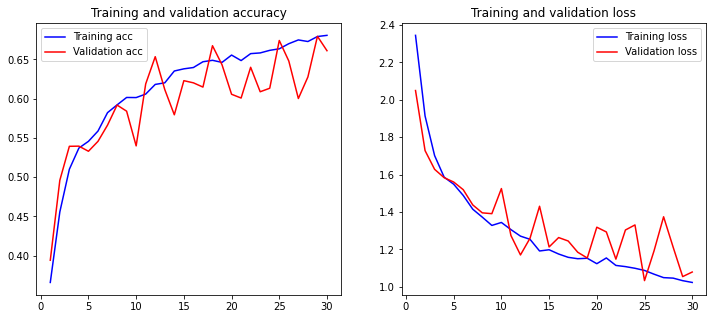

In [69]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Dense(256, activation='relu',input_shape=(None,13)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(512, return_sequences=True,dropout=0.2)))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    tf.keras.backend.clear_session()
    
    
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=50,steps_per_epoch=1000,epochs=30, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=500,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: "+str(moy_train/k))
    print("Testing Accuracy: "+str(moy_test/k)+"\n")
    plot_history(history)
    model.save("models/BI_LSTM_512_30epochs.h5")
    
    t0 = time.time()
    pred_labels = []
    true_labels = []

    for i in range(0,len(test_mfcc)):
        pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
        pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
        true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

    flat_pred = [item for sublist in pred_labels for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    print("Phone accuracy on full test set: "+str(accuracy_score(flat_true, flat_pred))+"\n")
    t1 = time.time()

    print("Time to evaluate the test set: "+str(t1-t0)+"\n")
        
    flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
    flat_vis_true = [visime_char_map[ph] for ph in flat_true]
    
    print("Visime accuracy on full test set: "+str(accuracy_score(flat_vis_true, flat_vis_pred))+"\n")

# 1024 LSTM nodes

Epoch 1/30
1000/1000 [==============================] - 56s 54ms/step - loss: 2.7662 - accuracy: 0.2948 - val_loss: 2.0611 - val_accuracy: 0.4163
Epoch 2/30
1000/1000 [==============================] - 53s 53ms/step - loss: 1.9376 - accuracy: 0.4492 - val_loss: 1.8905 - val_accuracy: 0.4621
Epoch 3/30
1000/1000 [==============================] - 54s 54ms/step - loss: 1.7591 - accuracy: 0.4951 - val_loss: 1.5857 - val_accuracy: 0.5315
Epoch 4/30
1000/1000 [==============================] - 53s 53ms/step - loss: 1.6390 - accuracy: 0.5249 - val_loss: 1.6819 - val_accuracy: 0.5137
Epoch 5/30
1000/1000 [==============================] - 53s 53ms/step - loss: 1.5245 - accuracy: 0.5523 - val_loss: 1.3878 - val_accuracy: 0.5925
Epoch 6/30
1000/1000 [==============================] - 53s 53ms/step - loss: 1.5207 - accuracy: 0.5546 - val_loss: 1.3922 - val_accuracy: 0.6063
Epoch 7/30
1000/1000 [==============================] - 55s 55ms/step - loss: 1.4397 - accuracy: 0.5740 - val_loss: 1.3609 -

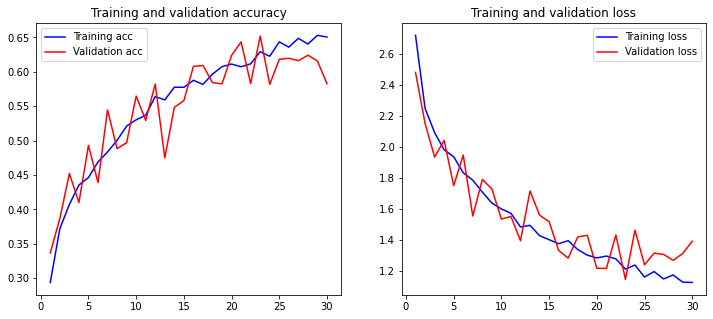

In [70]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Dense(512, activation='relu',input_shape=(None,13)))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(1024, return_sequences=True,dropout=0.2)))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    tf.keras.backend.clear_session()
    
    
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=50,steps_per_epoch=1000,epochs=30, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=500,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: "+str(moy_train/k))
    print("Testing Accuracy: "+str(moy_test/k)+"\n")
    plot_history(history)
    model.save("models/BI_LSTM_1024_30epochs.h5")
    
    t0 = time.time()
    pred_labels = []
    true_labels = []

    for i in range(0,len(test_mfcc)):
        pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
        pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
        true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

    flat_pred = [item for sublist in pred_labels for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    print("Phone accuracy on full test set: "+str(accuracy_score(flat_true, flat_pred))+"\n")
    t1 = time.time()

    print("Time to evaluate the test set: "+str(t1-t0)+"\n")
        
    flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
    flat_vis_true = [visime_char_map[ph] for ph in flat_true]
    
    print("Visime accuracy on full test set: "+str(accuracy_score(flat_vis_true, flat_vis_pred))+"\n")

# Dropout 0.1

Epoch 1/30
1000/1000 [==============================] - 27s 25ms/step - loss: 2.6433 - accuracy: 0.3057 - val_loss: 1.9057 - val_accuracy: 0.4556
Epoch 2/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.8346 - accuracy: 0.4686 - val_loss: 1.5837 - val_accuracy: 0.5273
Epoch 3/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.6933 - accuracy: 0.5146 - val_loss: 1.7777 - val_accuracy: 0.4990
Epoch 4/30
1000/1000 [==============================] - 25s 25ms/step - loss: 1.4847 - accuracy: 0.5630 - val_loss: 1.5257 - val_accuracy: 0.5662
Epoch 5/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.4996 - accuracy: 0.5626 - val_loss: 1.5118 - val_accuracy: 0.5648
Epoch 6/30
1000/1000 [==============================] - 25s 25ms/step - loss: 1.3717 - accuracy: 0.5911 - val_loss: 1.4675 - val_accuracy: 0.5674
Epoch 7/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.3850 - accuracy: 0.5861 - val_loss: 1.4784 -

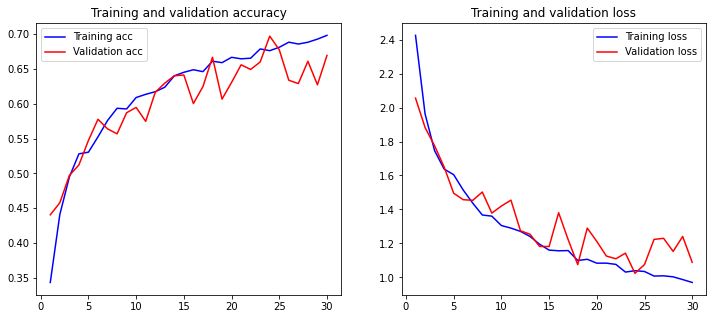

In [71]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Dense(256, activation='relu',input_shape=(None,13)))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(512, return_sequences=True,dropout=0.1)))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    tf.keras.backend.clear_session()
    
    
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=500,steps_per_epoch=1000,epochs=30, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=500,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: "+str(moy_train/k))
    print("Testing Accuracy: "+str(moy_test/k)+"\n")
    plot_history(history)
    model.save("models/BI_LSTM_512_30epochs_dropout01.h5")
    
    t0 = time.time()
    pred_labels = []
    true_labels = []

    for i in range(0,len(test_mfcc)):
        pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
        pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
        true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

    flat_pred = [item for sublist in pred_labels for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    print("Phone accuracy on full test set: "+str(accuracy_score(flat_true, flat_pred))+"\n")
    t1 = time.time()

    print("Time to evaluate the test set: "+str(t1-t0)+"\n")
        
    flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
    flat_vis_true = [visime_char_map[ph] for ph in flat_true]
    
    print("Visime accuracy on full test set: "+str(accuracy_score(flat_vis_true, flat_vis_pred))+"\n")

Epoch 1/30
1000/1000 [==============================] - 26s 24ms/step - loss: 2.8079 - accuracy: 0.2716 - val_loss: 2.0759 - val_accuracy: 0.4131
Epoch 2/30
1000/1000 [==============================] - 24s 24ms/step - loss: 2.0138 - accuracy: 0.4303 - val_loss: 1.9328 - val_accuracy: 0.4618
Epoch 3/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.8028 - accuracy: 0.4824 - val_loss: 1.7150 - val_accuracy: 0.5039
Epoch 4/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.7248 - accuracy: 0.4996 - val_loss: 1.7017 - val_accuracy: 0.5167
Epoch 5/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.6800 - accuracy: 0.5129 - val_loss: 1.5672 - val_accuracy: 0.5371
Epoch 6/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.5693 - accuracy: 0.5423 - val_loss: 1.6677 - val_accuracy: 0.5050
Epoch 7/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.5698 - accuracy: 0.5400 - val_loss: 1.5798 -

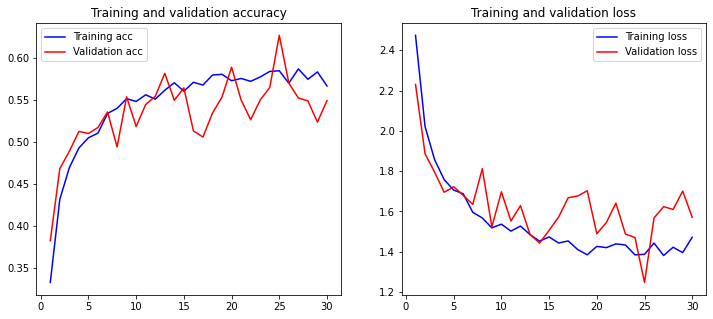

In [72]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Dense(256, activation='relu',input_shape=(None,13)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(512, return_sequences=True,dropout=0.5)))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    tf.keras.backend.clear_session()
    
    
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=500,steps_per_epoch=1000,epochs=30, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=500,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: "+str(moy_train/k))
    print("Testing Accuracy: "+str(moy_test/k)+"\n")
    plot_history(history)
    model.save("models/BI_LSTM_512_30epochs_dropout05.h5")
    
    t0 = time.time()
    pred_labels = []
    true_labels = []

    for i in range(0,len(test_mfcc)):
        pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
        pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
        true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

    flat_pred = [item for sublist in pred_labels for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    print("Phone accuracy on full test set: "+str(accuracy_score(flat_true, flat_pred))+"\n")
    t1 = time.time()

    print("Time to evaluate the test set: "+str(t1-t0)+"\n")
        
    flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
    flat_vis_true = [visime_char_map[ph] for ph in flat_true]
    
    print("Visime accuracy on full test set: "+str(accuracy_score(flat_vis_true, flat_vis_pred))+"\n")

Epoch 1/30
1000/1000 [==============================] - 26s 25ms/step - loss: 2.5993 - accuracy: 0.3122 - val_loss: 1.9631 - val_accuracy: 0.4552
Epoch 2/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.7954 - accuracy: 0.4842 - val_loss: 1.7029 - val_accuracy: 0.5096
Epoch 3/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.6576 - accuracy: 0.5207 - val_loss: 1.6515 - val_accuracy: 0.4978
Epoch 4/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.5455 - accuracy: 0.5498 - val_loss: 1.5040 - val_accuracy: 0.5562
Epoch 5/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.4620 - accuracy: 0.5670 - val_loss: 1.4162 - val_accuracy: 0.5751
Epoch 6/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.4532 - accuracy: 0.5692 - val_loss: 1.3316 - val_accuracy: 0.5944
Epoch 7/30
1000/1000 [==============================] - 24s 24ms/step - loss: 1.3545 - accuracy: 0.5944 - val_loss: 1.4106 -

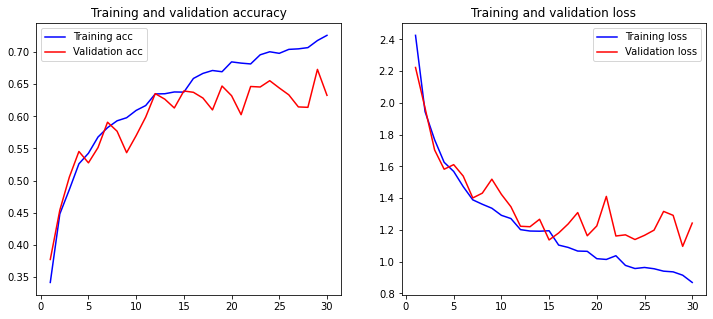

In [73]:
with tf.device('/device:GPU:0'):
    model = Sequential()
    model.add(Dense(256, activation='relu',input_shape=(None,13)))
    model.add(Dense(512, activation='relu'))
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Dense(61, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    tf.keras.backend.clear_session()
    
    
    fold = 0
    Scores_train = []
    Scores_test = []
    k = 5
    Wsave = model.get_weights()


    kf = KFold(n_splits=k, shuffle=True, random_state=123)

    for train_index, test_index in kf.split(train_mfcc):
        model.set_weights(Wsave)

        history = model.fit(train_valid_generator(train_index),validation_data=train_valid_generator(test_index),validation_steps=500,steps_per_epoch=1000,epochs=30, verbose=1)
        loss_train, accuracy_train = model.evaluate(train_valid_generator(train_index),steps=500,verbose=False)

        Scores_train.append(accuracy_train)
        loss_test, accuracy_test = model.evaluate(train_valid_generator(test_index),steps=500,verbose=False)
        Scores_test.append(accuracy_test)

        fold += 1


    moy_test = 0
    moy_train = 0

    for i in range(k):
        moy_test += Scores_test[i]
        moy_train += Scores_train[i]

    print("Training Accuracy: "+str(moy_train/k))
    print("Testing Accuracy: "+str(moy_test/k)+"\n")
    plot_history(history)
    model.save("models/BI_LSTM_512_30epochs_dropout01.h5")
    
    t0 = time.time()
    pred_labels = []
    true_labels = []

    for i in range(0,len(test_mfcc)):
        pred = model.predict(test_mfcc[i].reshape((1,test_mfcc[i].shape[0],test_mfcc[i].shape[1])))
        pred_labels.append([timit_index_map[np.argmax(ph)] for ph in  pred[0]])
        true_labels.append([timit_index_map[np.argmax(ph)] for ph in  test_phn[i]])

    flat_pred = [item for sublist in pred_labels for item in sublist]
    flat_true = [item for sublist in true_labels for item in sublist]

    print("Phone accuracy on full test set: "+str(accuracy_score(flat_true, flat_pred))+"\n")
    t1 = time.time()

    print("Time to evaluate the test set: "+str(t1-t0)+"\n")
        
    flat_vis_pred = [visime_char_map[ph] for ph in flat_pred]
    flat_vis_true = [visime_char_map[ph] for ph in flat_true]
    
    print("Visime accuracy on full test set: "+str(accuracy_score(flat_vis_true, flat_vis_pred))+"\n")